# redMaPPer CasJobs

The goal of this notebook is to document how we retrieve the complete set of updated (DR14) SDSS *ugriz* and unWISE *W1-W4* (forced) photometry for the parent sample of redMaPPer central galaxies.

In [1]:
import os
import numpy as np

from astropy.table import Table, Column
import fitsio

### Write a simple ASCII file with redMaPPer ID and the CAS-compatible ObjID.

We begin by generating a simple file which can be uploaded to CasJobs.  

In the first attempt we tried to cross-match using the unique ObjID constructed from the PhotoID in the parent redMaPPer catalog, but we found that 43/396047 objects were "missing".  The issue turned out to be that some of the PhotoID values in the redMaPPer catalog pointed to objects in CAS with "poor" photometry.  Here's one example of the same object with different ObjIDs -- one "good" and one "poor."  
    http://skyserver.sdss.org/dr14/en/tools/explore/Summary.aspx?id=1237655109445025964  
    http://skyserver.sdss.org/dr14/en/tools/explore/Summary.aspx?id=1237655109445091465

We then experimented with using the RA,Dec coordinates to do a nearest-neighbor search.  However, this was unsatisfactory for a couple reasons.  First, uploading an ASCII catalog to CasJobs renders the Ra,Dec values single-precision, which can cause issues when matching.  And second, we were concerned that spurious matches would occur, introducing unwanted systematic problems in the redMaPPer catalog.

In the end we used a nearest-neighbor search (1 arcsec search radius) to retrieve updated ObjIDs for the "missing" 49 objects and matched 

In [2]:
def read_redmapper(rmversion='v6.3.1', index=None):
    """Read the parent redMaPPer catalog.
    
    """
    rmfile = os.path.join( os.getenv('REDMAPPER_DIR'), rmversion, 
                          'dr8_run_redmapper_{}_lgt5_catalog.fit'.format(rmversion) )
    if index is not None:
        rm = Table(fitsio.read(rmfile, ext=1, upper=True, rows=index))
    else:
        rm = Table(fitsio.read(rmfile, ext=1, upper=True))
    print('Read {} objects from {}'.format(len(rm), rmfile))

    return rm

In [3]:
rmversion = 'v6.3.1'

In [26]:
rm = read_redmapper(rmversion=rmversion)
nobj = len(rm)
rm

Read 396047 objects from /Users/ioannis/research/data/redmapper/v6.3.1/dr8_run_redmapper_v6.3.1_lgt5_catalog.fit


MEM_MATCH_ID,RA,DEC,MODEL_MAG [5],MODEL_MAGERR [5],IMAG,IMAG_ERR,ZRED,ZRED_E,ZRED_CHISQ,BCG_SPEC_Z,Z_SPEC_INIT,Z_INIT,Z,LAMBDA_CHISQ,LAMBDA_CHISQ_E,LAMBDA_ZRED,LAMBDA_ZRED_E,R_LAMBDA,SCALEVAL,MASKFRAC,C_LAMBDA [4],C_LAMBDA_ERR [4],MAG_LAMBDA_ERR [5],CHISQ,Z_LAMBDA,Z_LAMBDA_E,Z_LAMBDA_NITER,EBV_MEAN,PHOTOID,LNLAMLIKE,LNBCGLIKE,LNLIKE,PZBINS [21],PZ [21],NCROSS,RMASK,RA_ORIG,DEC_ORIG,W,DLAMBDA_DZ,DLAMBDA_DZ2,DLAMBDAVAR_DZ,DLAMBDAVAR_DZ2,LAMBDA_CHISQ_C,LAMBDA_CHISQ_CE,NCENT,NCENT_GOOD,RA_CENT [5],DEC_CENT [5],ID_CENT [5],LAMBDA_CHISQ_CENT [5],ZLAMBDA_CENT [5],P_BCG [5],P_CEN [5],Q_CEN [5],P_FG [5],Q_MISS,P_SAT [5],P_C [5],BCG_ILUM,ILUM,Z_LAMBDA_RAW,Z_LAMBDA_E_RAW,LIM_EXPTIME,LIM_LIMMAG,LIM_LIMMAG_HARD
int32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,int64,float32,float32,float32,float32,float32,int16,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,int16,int16,float64,float64,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
1,239.583329069,27.2334129178,17.7673 .. 13.6197,0.0495718 .. 0.00515177,13.979,0.00269815,0.0976015,0.00598646,17.5295,0.0908067,0.0908067,0.0976015,0.0995999,169.838,4.18703,167.9,3.82714,1.11175,1.01137,0.012301,1.91101 .. 0.340558,0.00478467 .. 0.00015905,0.0047196 .. 0.0,17.1603,0.0948307,0.00458178,1,0.0156272,39270301200850016,417.533,3.98176,421.515,0.0689421 .. 0.120719,6.66542e-06 .. 8.29784e-06,1,1.66762,239.583329069,27.2334129178,1.09264,22.1429,-1019.21,431.903,85493.5,169.368,1.24138,5,2,239.583329069 .. 239.559634173,27.2334129178 .. 27.2721026726,25404293 .. 25404056,169.838 .. 165.795,0.0964975 .. 0.0,1.0 .. 1.0,0.874838 .. 5.36843e-07,0.752766 .. 4.61934e-07,0.000188751 .. 0.00250284,-4.7971,0.124973 .. 0.997497,0.843622 .. 3.31047e-06,7.45976,115.15,0.0964975,0.0015025,122.966,21.1772,21.2911
2,250.082548387,46.7115313536,19.7931 .. 15.8147,0.144956 .. 0.0193181,16.2903,0.0075439,0.263556,0.00704976,16.1534,-1.0,-1.0,0.233135,0.233327,199.539,5.29983,173.621,5.04967,1.14817,0.995171,0.0,1.80072 .. 0.32185,0.116592 .. 0.00175495,0.115213 .. 0.0,22.2347,0.232764,0.00615558,1,0.0268378,14530301500570247,382.432,1.15807,383.59,0.196232 .. 0.269297,3.38395e-07 .. 5.93477e-06,1,1.72225,250.086476355,46.7122681373,1.25965,7.30459,-56.4033,228.875,22720.9,199.594,0.463512,5,2,250.082548387 .. 250.107576522,46.7115313536 .. 46.7094645939,3352952 .. 3352965,199.539 .. 210.08,0.231425 .. 0.0,1.0 .. 1.0,0.985673 .. 3.25354e-06,0.633526 .. 2.09117e-06,0.0115227 .. 0.129715,-2.05149,0.00280448 .. 0.870282,0.639414 .. 5.85322e-06,5.72643,132.716,0.231425,0.00207641,94.0304,21.0016,21.2911
3,197.872957171,-1.34111627953,20.4303 .. 15.0278,0.495924 .. 0.0141083,15.3854,0.00549334,0.193564,0.00764036,32.7315,-1.0,-1.0,0.165282,0.185414,164.712,4.24162,157.558,3.99728,1.10496,1.00655,0.00508906,1.83547 .. 0.321014,0.0797838 .. 0.00102912,0.0790554 .. 0.0,34.0984,0.182398,0.00393653,1,0.0221436,23340301600130074,372.586,2.67244,375.259,0.159875 .. 0.204921,8.13114e-06 .. 1.31497e-05,1,1.65743,197.876240818,-1.34142305978,1.46013,2.03778,-741.054,128.44,24408.3,164.286,0.620295,5,3,197.872957171 .. 197.886363462,-1.34111627953 .. -1.32545764765,9222531 .. 9222794,164.712 .. 160.685,0.184493 .. 0.0,1.0 .. 1.0,0.660098 .. 0.000373478,0.653537 .. 0.000369766,0.000265913 .. 0.0163708,-18.7437,0.339636 .. 0.983256,0.98502 .. 0.0358702,8.11466,118.677,0.184493,0.00164668,85.9083,20.9194,21.2911
4,230.600091876,27.7143690526,17.7457 .. 14.1279,0.0249274 .. 0.00438643,14.449,0.00252544,0.0758894,0.00859367,3.21969,0.069041,-1.0,0.0535868,0.0786437,133.256,4.30238,133.333,3.49261,1.0591,1.0523,0.0482489,1.87192 .. 0.316875,0.00237442 .. 0.00010312,0.00233411 .. 0.0,2.20879,0.0774831,0.00579991,2,0.0156272,45120301202090548,370.72,

#### Convert the PhotoID in the redMaPPer catalog to ObjID using utilities written by Erin Sheldon.

In [5]:
def unpack_photoid(photoid):
    """Unpack the SDSS photoID into run, rerun, camcol, field, and id.
    
    The heart of this code is adopted from Erin Sheldon's 
    sdsspy.util.photoid_extract.

    """    
    import numpy as np
    
    pvals = [13,9,8,4,0]

    ten = np.array(10, dtype='i8')

    run = photoid // ten**pvals[0]
    rerun = photoid // ten**pvals[1] - run*ten**(pvals[0]-pvals[1])

    camcol = \
        photoid // ten**pvals[2] - \
        run * ten**(pvals[0]-pvals[2]) - \
        rerun * ten**(pvals[1]-pvals[2])

    field = \
        photoid // ten**pvals[3] - \
        run * ten**(pvals[0]-pvals[3]) - \
        rerun * ten**(pvals[1]-pvals[3]) - \
        camcol * ten**(pvals[2]-pvals[3])

    id = \
        photoid // ten**pvals[4] - \
        run * ten**(pvals[0]-pvals[4]) - \
        rerun * ten**(pvals[1]-pvals[4]) - \
        camcol * ten**(pvals[2]-pvals[4]) - \
        field * ten**(pvals[3]-pvals[4])

    return run, rerun, camcol, field, id

In [34]:
def unpack_objid(objid, everything=False):
    """Unpack the SDSS ObjID into run, rerun, camcol, field, and id.
    
    The heart of this code is adopted from Erin Sheldon's 
    sdsspy.util.objid_extract.

    """    
    masks = {
        'sky_version': 0x7800000000000000,
        'rerun': 0x07FF000000000000,
        'run': 0x0000FFFF00000000,
        'camcol': 0x00000000E0000000,
        'first_field': 0x0000000010000000,
        'field': 0x000000000FFF0000,
        'id': 0x000000000000FFFF
    }

    run = (objid & masks['run']) >> 32
    rerun = (objid & masks['rerun']) >> 48
    camcol = (objid & masks['camcol']) >> 29
    field = (objid & masks['field']) >> 16
    id = (objid & masks['id']) >> 0
    sky_version = (objid & masks['sky_version']) >> 59
    first_field = (objid & masks['first_field']) >> 28
    
    if everything:
        return run, rerun, camcol, field, id, first_field, sky_version
    else:
        return run, rerun, camcol, field, id

In [6]:
def get_objid(run, rerun, camcol, field, id, skyversion=2):
    """Convert run, rerun, camcol, field, and id to an ObjID used 
    by the SDSS CAS.
    
    The heart of this code is adopted from Erin Sheldon's 
    sdsspy.util.get_odjid.

    """    
    import numpy as np
    
    dt = 'i8'
    sky    = np.array(skyversion, ndmin=1, dtype=dt, copy=False)
    run    = np.array(run, ndmin=1, dtype=dt, copy=False)
    rerun  = np.array(rerun, ndmin=1, dtype=dt, copy=False)
    camcol = np.array(camcol, ndmin=1, dtype=dt, copy=False)
    field  = np.array(field, ndmin=1, dtype=dt, copy=False)
    id     = np.array(id, ndmin=1, dtype=dt, copy=False)
    
    objid = np.zeros(run.size, dtype=dt)

    first_field = np.zeros(run.size, dtype=dt)
    objid = (objid
             | (sky << 59)
             | (rerun << 48)
             | (run << 32)
             | (camcol << 29)
             | (first_field << 28)
             | (field << 16)
             | (id << 0) )

    return objid    

In [7]:
photoid = rm['PHOTOID'].data
run, rerun, camcol, field, id = unpack_photoid(photoid)
objid = get_objid(run, rerun, camcol, field, id)

#### [1] Match using the original ObjID.

Write out an ASCII file with the original ObjID, upload it to CasJobs (naming the table "redmapper_originalobjid_in", execute the following SQL query (using the DR14 Context), and download the resulting table, "redmapper_originalobjid_out".

```SQL
SELECT
  m.redmapper_id,
  m.redmapper_objid,
  p.objid,
  p.ra,
  p.dec,
  p.run,
  p.rerun,
  p.camcol
INTO mydb.redmapper_originalobjid_out FROM mydb.redmapper_originalobjid_in AS m
  JOIN dr14.PhotoObj AS p ON m.redmapper_objid=p.objid
ORDER BY m.redmapper_id
```

In [8]:
casfile = os.path.join( os.getenv('REDMAPPER_DIR'), rmversion, 'casjobs', 
                       'redmapper_originalobjid_in.txt'.format(rmversion) )
if os.path.isfile(casfile):
    print('CasJobs file {} exists.'.format(casfile))
else:
    print('Writing {}'.format(casfile))
    np.savetxt( casfile, np.vstack( [ [rm['MEM_MATCH_ID']], [objid] ] ).T, 
               header='redmapper_id redmapper_objid', fmt=('%i', '%i') )

CasJobs file /Users/ioannis/research/data/redmapper/v6.3.1/casjobs/redmapper_originalobjid_in.txt exists.


#### [2] Gather photometry of missing objects.

Read the output of the previous step and determine which objects are missing.  Then write out and upload a new CasJobs file with the RA,Dec coordinates of the missing objects (calling the table "redmapper_missing_in"), execute the following SQL query (again using the DR14 Context), and download the resulting table, "redmapper_missing_out".

Note that we write out an XML table because CasJobs does not maintain the double precision of the RA,Dec coordinates in the ASCII file.

Also note that we use a generous 5 arcsec search radius.

```SQL
SELECT
  m.redmapper_id,
  m.redmapper_objid,
  m.redmapper_ra,
  m.redmapper_dec,
  p.objid,
  p.ra,
  p.dec,
  p.run,
  p.rerun,
  p.camcol
INTO mydb.redmapper_missing_out FROM mydb.redmapper_missing_in AS m
  OUTER APPLY dbo.fGetNearestObjEq( m.redmapper_ra, m.redmapper_dec, 0.01666) AS n 
  LEFT JOIN dr14.PhotoObj AS p ON n.objid=p.objid
ORDER BY m.redmapper_id
```

In [9]:
originalfile = os.path.join( os.getenv('REDMAPPER_DIR'), rmversion, 'casjobs',
                            'redmapper_originalobjid_out.fits' )
oo = Table(fitsio.read(originalfile, ext=1, upper=True))
print('Read {} objects from {}'.format(len(oo), originalfile))

Read 396004 objects from /Users/ioannis/research/data/redmapper/v6.3.1/casjobs/redmapper_originalobjid_out.fits


In [10]:
notmissing = np.where(np.in1d(rm['MEM_MATCH_ID'], oo['REDMAPPER_ID']))[0]
missing = np.where(~np.in1d(rm['MEM_MATCH_ID'], oo['REDMAPPER_ID']))[0]
print('The following {} objects did not match on their original ObjID:'.format(len(missing)))
rm[missing]

The following 43 objects did not match on their original ObjID:


MEM_MATCH_ID,RA,DEC,MODEL_MAG [5],MODEL_MAGERR [5],IMAG,IMAG_ERR,ZRED,ZRED_E,ZRED_CHISQ,BCG_SPEC_Z,Z_SPEC_INIT,Z_INIT,Z,LAMBDA_CHISQ,LAMBDA_CHISQ_E,LAMBDA_ZRED,LAMBDA_ZRED_E,R_LAMBDA,SCALEVAL,MASKFRAC,C_LAMBDA [4],C_LAMBDA_ERR [4],MAG_LAMBDA_ERR [5],CHISQ,Z_LAMBDA,Z_LAMBDA_E,Z_LAMBDA_NITER,EBV_MEAN,PHOTOID,LNLAMLIKE,LNBCGLIKE,LNLIKE,PZBINS [21],PZ [21],NCROSS,RMASK,RA_ORIG,DEC_ORIG,W,DLAMBDA_DZ,DLAMBDA_DZ2,DLAMBDAVAR_DZ,DLAMBDAVAR_DZ2,LAMBDA_CHISQ_C,LAMBDA_CHISQ_CE,NCENT,NCENT_GOOD,RA_CENT [5],DEC_CENT [5],ID_CENT [5],LAMBDA_CHISQ_CENT [5],ZLAMBDA_CENT [5],P_BCG [5],P_CEN [5],Q_CEN [5],P_FG [5],Q_MISS,P_SAT [5],P_C [5],BCG_ILUM,ILUM,Z_LAMBDA_RAW,Z_LAMBDA_E_RAW,LIM_EXPTIME,LIM_LIMMAG,LIM_LIMMAG_HARD
int32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,int64,float32,float32,float32,float32,float32,int16,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,int16,int16,float64,float64,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
22471,155.76300038,57.5615379001,22.7153 .. 17.4953,0.880832 .. 0.0297911,17.8287,0.0128143,0.317341,0.0148829,1.73192,0.334343,0.334343,0.317341,0.340901,22.2765,2.50593,13.4133,1.9087,0.740575,0.99349,0.0,1.5387 .. 0.359179,0.568845 .. 0.00645501,0.54381 .. 0.0,1.31372,0.349267,0.0179885,1,0.137114,22430301602360137,22.8763,-0.565203,22.3111,0.255227 .. 0.443307,3.93495e-07 .. 2.60973e-06,1,1.11086,155.76300038,57.5615379001,1.43552,8.17327,-258.758,53.0877,-1491.2,22.2765,0.0,5,1,155.76300038 .. 155.746162377,57.5615379001 .. 57.589205812,7638018 .. 7638050,22.2765 .. 0.0,0.334937 .. 0.0,1.0 .. 1.0,0.998829 .. 1.11465e-06,0.791207 .. 8.82951e-07,8.18993e-05 .. 0.487252,-2.90574,0.00108945 .. 0.512747,0.791942 .. 4.24769e-06,3.30616,14.6403,0.334937,0.012719,109.83,21.1386,21.2911
30043,224.46574546,56.9384951721,23.0463 .. 18.2324,0.552041 .. 0.0325983,18.4954,0.0148845,0.385174,0.0133786,1.61488,-1.0,-1.0,0.385174,0.357582,26.5784,3.0714,13.7795,2.26598,0.767195,1.00871,0.0130764,1.23034 .. 0.380735,0.24375 .. 0.0063605,0.227909 .. 0.0,2.95253,0.364688,0.0166829,1,0.00991823,61220301500120272,19.3478,0.656011,20.0038,0.282366 .. 0.44701,4.21125e-05 .. 2.415e-06,1,1.15079,224.46574546,56.9384951721,1.07564,10.7551,-1062.49,39.5108,-7499.6,26.4808,0.417877,5,3,224.46574546 .. 224.497742729,56.9384951721 .. 56.9477772031,46017769 .. 46017813,26.5784 .. 21.651,0.351733 .. 0.0,1.0 .. 1.0,0.910682 .. 0.00399157,0.078888 .. 0.00034577,0.0349133 .. 0.298359,0.0610055,0.0544051 .. 0.69765,0.0795031 .. 0.00037842,2.01451,17.6802,0.351733,0.0106678,117.391,21.2009,21.2911
54556,131.248874873,57.0979488789,21.6514 .. 18.1365,0.423332 .. 0.0593842,18.5615,0.0242982,0.469142,0.0118804,7.31877,0.463189,0.463189,0.469142,0.442732,32.8329,7.27363,26.0139,4.38038,0.800317,1.91532,0.0748722,2.57605 .. 0.37638,1.20851 .. 0.0329465,1.0851 .. 0.0,9.62118,0.451084,0.0161992,2,0.137114,42080301101820335,13.3664,1.84391,15.2104,0.351004 .. 0.551164,3.6402e-06 .. 2.85553e-06,2,1.20048,131.248874873,57.0979488789,1.32246,4.51707,-187.842,671.52,-47052.4,32.8329,0.0,5,1,131.248874873 .. 131.262179008,57.0979488789 .. 57.0860657396,27659406 .. 27659226,32.8329 .. 0.0,0.437941 .. 0.0,1.0 .. 1.0,0.995089 .. 0.00019121,0.716645 .. 0.000137706,0.00179335 .. 0.236449,-1.84476,0.00311772 .. 0.76336,0.719189 .. 0.000491884,3.2059,16.2029,0.437941,0.0129837,76.6538,20.6913,21.2911
63828,229.866575853,11.6052448738,25.1007 .. 18.0913,2.10731 .. 0.0474661,18.5117,0.0217141,0.413849,0.0107661,3.3345,0.435419,-1.0,0.456392,0.441699,16.8152,3.06125,6.28926,1.77933,0.700068,1.11486,0.0,1.47034 .. 0.394161,0.5954 .. 0.0163549,0.543426 .. 0.0,5.36831,0.394102,0.0211677,7,0.0248643,39960301501700546,12.0433,-3.62422,8.41905,0.296741 .. 0.491462,0.0149743 .. 2.31

In [11]:
print('For the record, the missing ObjIDs are:')
print(objid[missing])

For the record, the missing ObjIDs are:
[1237655109445091465 1237671769071681808 1237663546367934799
 1237662637981565474 1237678919139590184 1237657858218524958
 1237654381441122664 1237659149922140393 1237658312402404334
 1237661386541498820 1237679454922866959 1237659133280059619
 1237655369292448339 1237651714797535660 1237678860072453257
 1237661150302765337 1237663787424940393 1237651537650254379
 1237662198821815431 1237658609294246073 1237654398081237216
 1237671766925377740 1237667536402907288 1237667916489490609
 1237651495224410309 1237667141793153337 1237651191363404083
 1237657770172416324 1237651271366607031 1237653613183631782
 1237668365315540259 1237663547439448844 1237651271887618529
 1237651250411930107 1237661435381023131 1237648705122206096
 1237657628994044375 1237651539778011687 1237648720677109765
 1237651273497706834 1237680530276876968 1237661417669919465
 1237665128546042063]


In [12]:
xml = True
if xml:
    suffix = 'xml'
else:
    suffix = 'txt'

In [13]:
missingfile = os.path.join( os.getenv('REDMAPPER_DIR'), rmversion, 'casjobs',
                           'redmapper_missing_in.{}'.format(suffix) )
if os.path.isfile(missingfile):
    print('CasJobs file {} exists.'.format(missingfile))
else:
    print('Writing {}'.format(missingfile))
    if xml:
        from astropy.io import votable
        out = Table()
        out.add_column(Column(data=rm['MEM_MATCH_ID'][missing], name='redmapper_id'))
        out.add_column(Column(data=objid[missing], name='redmapper_objid'))
        out.add_column(Column(data=rm['RA'][missing], name='redmapper_ra'))
        out.add_column(Column(data=rm['DEC'][missing], name='redmapper_dec'))
        out_votable = votable.from_table(out)
        votable.writeto(out_votable, missingfile)
    else:
        np.savetxt( missingfile, np.vstack( [ [rm['MEM_MATCH_ID'][missing]], [objid[missing]], 
                                             [rm['RA'][missing]], [rm['DEC'][missing]] ] ).T, 
                   header='redmapper_id redmapper_objid redmapper_ra redmapper_dec', 
                   fmt=('%i', '%i', '%16.10f', '%16.10f') )

CasJobs file /Users/ioannis/research/data/redmapper/v6.3.1/casjobs/redmapper_missing_in.xml exists.


#### [3] Attempt to do a by-hand search for the last few missing objects.

At this point we are still missing photometry for 8/43 objects, so we use [Navigate](http://skyserver.sdss.org/dr14/en/tools/chart/navi.aspx) to try to find them.  Although we find that we can recover ObjIDs for all of them, 4 have a *"WARNING: This object's photometry may be unreliable. See the photometric flags below."*, and so these objects will not be matched when we execute our final SQL query in step [4].

At the end of this step we gather all the updated ObjIDs.

In [14]:
missingoutfile = os.path.join( os.getenv('REDMAPPER_DIR'), rmversion, 'casjobs', 
                              'redmapper_missing_out.fits' )
mm = Table(fitsio.read(missingoutfile, ext=1, upper=True))
print('Read {} objects from {}'.format(len(mm), missingoutfile))

Read 43 objects from /Users/ioannis/research/data/redmapper/v6.3.1/casjobs/redmapper_missing_out.fits


In [15]:
stillnotmissing = np.where(mm['OBJID'] > 0)[0]
stillmissing = np.where(mm['OBJID'] < 0)[0]
print('The following {} objects are still missing ObjIDs:'.format(len(stillmissing)))
mm[stillmissing]

The following 8 objects are still missing ObjIDs:


REDMAPPER_ID,REDMAPPER_OBJID,REDMAPPER_RA,REDMAPPER_DEC,OBJID,RA,DEC,RUN,RERUN,CAMCOL
int32,int64,float64,float64,int64,float64,float64,int16,int16,uint8
85666,1237678919139590184,20.2430974665,11.6518175043,-9223372036854775808,nan,nan,-32768,-32768,128
145282,1237659149922140393,221.771688092,54.2201103797,-9223372036854775808,nan,nan,-32768,-32768,128
163434,1237658312402404334,176.835810591,60.0896418644,-9223372036854775808,nan,nan,-32768,-32768,128
202893,1237651537650254379,236.566132652,54.9171156958,-9223372036854775808,nan,nan,-32768,-32768,128
365649,1237651271366607031,201.20658089,65.5829127834,-9223372036854775808,nan,nan,-32768,-32768,128
398209,1237651271887618529,130.075945026,52.9345376097,-9223372036854775808,nan,nan,-32768,-32768,128
425203,1237657628994044375,191.338957026,51.911202363,-9223372036854775808,nan,nan,-32768,-32768,128
469002,1237648720677109765,141.661187499,-0.515480572129,-9223372036854775808,nan,nan,-32768,-32768,128


The original ("old") and updated ("new") ObjIDs were found by doing a nearest search query using Navigate.  The objects flagged "BAD" have a "this object's photometry may be unreliable" warning.

In [16]:
oldandnew = [ 
    (1237678919139590184, 1237678858480255092, 'OK'),
    (1237659149922140393, 1237659149922140394, 'BAD'),
    (1237658312402404334, 1237658312402404326, 'OK'),
    (1237651537650254379, 1237651537650254378, 'OK'),
    (1237651271366607031, 1237651271366607032, 'BAD'),
    (1237651271887618529, 1237651700840923446, 'BAD'),
    (1237657628994044375, 1237657628994044078, 'OK'),
    (1237648720677109765, 1237648720677044442, 'BAD')
]             

In [17]:
newobjid = np.zeros_like(objid)
newobjid[notmissing] = objid[notmissing]
newobjid[missing[stillnotmissing]] = mm['OBJID'][stillnotmissing].data
for indx, oandn in zip( missing[stillmissing], oldandnew ):
    newobjid[indx] = oandn[1]
assert(np.sum(newobjid == 0) == 0)

#### [4] Gather the final SDSS + unWISE photometry.

Finally, we construct one more CasJobs input file with the updated ObjIDs and request the full set of SDSS (*ugriz*) and unWISE (*W1W2*) forced photometry by executing the following query.  We call the input table "redmapper_newobjid" and the output (FITS) table "redmapper_sdssWisephot.fits".

In the final step we read the output FITS table, collect all the photometry (converted into *sdsswise_maggies* and *sdsswise_ivarmaggies*), and write out the final photometric table.

```SQL
SELECT
  m.redmapper_id,
  m.redmapper_objid,
  p.objid,
  p.ra,
  p.dec,
  p.run,
  p.rerun,
  p.camcol,
  p.field,
  p.type,
  p.petromag_u,
  p.petromag_g,
  p.petromag_r,
  p.petromag_i,
  p.petromag_z,
  p.petromagerr_u,
  p.petromagerr_g,
  p.petromagerr_r,
  p.petromagerr_i,
  p.petromagerr_z,
  p.modelmag_u,
  p.modelmag_g,
  p.modelmag_r,
  p.modelmag_i,
  p.modelmag_z,
  p.modelmagerr_u,
  p.modelmagerr_g,
  p.modelmagerr_r,
  p.modelmagerr_i,
  p.modelmagerr_z,
  p.cmodelmag_u,
  p.cmodelmag_g,
  p.cmodelmag_r,
  p.cmodelmag_i,
  p.cmodelmag_z,
  p.cmodelmagerr_u,
  p.cmodelmagerr_g,
  p.cmodelmagerr_r,
  p.cmodelmagerr_i,
  p.cmodelmagerr_z,
  p.extinction_u,
  p.extinction_g,
  p.extinction_r,
  p.extinction_i,
  p.extinction_z,
  p.petroR50_u,
  p.petroR50_g,
  p.petroR50_r,
  p.petroR50_i,
  p.petroR50_z,
  f.w1_nanomaggies,
  f.w1_nanomaggies_ivar,
  f.w2_nanomaggies,
  f.w2_nanomaggies_ivar
INTO mydb.redmapper_sdssWISEphot from mydb.redmapper_newobjid as m
  JOIN dr14.PhotoObj AS p ON m.redmapper_objid=p.objid
  JOIN dr14.wiseForcedTarget AS f ON m.redmapper_objid=f.objid
ORDER BY m.redmapper_id
```

In [18]:
finalcasfile = os.path.join( os.getenv('REDMAPPER_DIR'), rmversion, 'casjobs', 
                       'redmapper_newobjid.txt'.format(rmversion) )
if os.path.isfile(finalcasfile):
    print('CasJobs file {} exists.'.format(finalcasfile))
else:
    print('Writing {}'.format(finalcasfile))
    np.savetxt( finalcasfile, np.vstack( [ [rm['MEM_MATCH_ID']], [newobjid] ] ).T, 
               header='redmapper_id redmapper_objid', fmt=('%i', '%i') )

CasJobs file /Users/ioannis/research/data/redmapper/v6.3.1/casjobs/redmapper_newobjid.txt exists.


In [28]:
inphotfile = os.path.join( os.getenv('REDMAPPER_DIR'), rmversion, 'casjobs',
                          'redmapper_sdssWISEphot.fits' )
inphot = Table(fitsio.read(inphotfile, ext=1, upper=True))
inphot[:3]

REDMAPPER_ID,REDMAPPER_OBJID,OBJID,RA,DEC,RUN,RERUN,CAMCOL,FIELD,TYPE,PETROMAG_U,PETROMAG_G,PETROMAG_R,PETROMAG_I,PETROMAG_Z,PETROMAGERR_U,PETROMAGERR_G,PETROMAGERR_R,PETROMAGERR_I,PETROMAGERR_Z,MODELMAG_U,MODELMAG_G,MODELMAG_R,MODELMAG_I,MODELMAG_Z,MODELMAGERR_U,MODELMAGERR_G,MODELMAGERR_R,MODELMAGERR_I,MODELMAGERR_Z,CMODELMAG_U,CMODELMAG_G,CMODELMAG_R,CMODELMAG_I,CMODELMAG_Z,CMODELMAGERR_U,CMODELMAGERR_G,CMODELMAGERR_R,CMODELMAGERR_I,CMODELMAGERR_Z,EXTINCTION_U,EXTINCTION_G,EXTINCTION_R,EXTINCTION_I,EXTINCTION_Z,PETROR50_U,PETROR50_G,PETROR50_R,PETROR50_I,PETROR50_Z,W1_NANOMAGGIES,W1_NANOMAGGIES_IVAR,W2_NANOMAGGIES,W2_NANOMAGGIES_IVAR
int32,int64,int64,float64,float64,int16,int16,uint8,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
1,1237662340012638224,1237662340012638224,239.583335437,27.2334095464,3927,301,2,85,3,17.5465,15.6517,14.3831,14.0365,13.4203,0.44279,0.504623,0.291299,0.34572,0.198605,18.0029,15.5808,14.5237,14.0696,13.6932,0.0495716,0.00378445,0.00272018,0.00269827,0.00515177,18.8245,15.6245,14.5237,14.0704,13.732,0.0504125,0.00378317,0.00272018,0.00269815,0.00514835,0.187233,0.145891,0.100927,0.0749992,0.0557857,101.315,14.1118,19.4193,16.3806,25.6271,39647.6,0.000414198,42470.3,4.17227e-05
2,1237651715872325879,1237651715872325879,250.082552977,46.7114748935,1453,301,5,57,3,19.2839,18.5895,16.9755,16.5143,16.7465,0.206395,0.0760255,0.0436355,0.0530121,0.184338,19.9227,18.065,16.6064,16.096,15.8425,0.144945,0.0142664,0.00695238,0.00729464,0.0193181,18.7568,18.3783,16.8196,16.3372,16.4022,0.12663,0.0147585,0.00719107,0.0075439,0.0197254,0.102034,0.0795039,0.0550005,0.0408712,0.0304007,10.4942,3.68733,4.49805,4.2099,2.44081,7234.43,0.00300798,8665.86,0.000288756
3,1237655500272500810,1237655500272500810,197.872956459,-1.3411176982,2334,301,6,13,3,30.0147,17.3442,16.0537,15.5904,17.4143,0.591237,0.677505,0.479361,0.355125,1.58031,20.5783,17.005,15.7668,15.3216,15.09,0.495789,0.0101349,0.00550487,0.00531618,0.0141083,21.8224,17.1378,15.8484,15.458,15.8316,0.420521,0.0104665,0.00561052,0.00549334,0.0143531,0.114984,0.0895949,0.0619813,0.0460588,0.0342593,-9999.0,6.99923,7.68177,7.68803,1.21615,12584.4,0.000359241,14754.4,3.38049e-05


In [42]:
match = np.in1d(rm['MEM_MATCH_ID'], inphot['REDMAPPER_ID'])
matchindx = np.where(match)[0]
missindx = np.where(~match)[0]

In [65]:
big = np.where( np.abs(3600 * (inphot['RA'] - rm['RA'][matchindx])) > 2 )[0]
print(newobjid[matchindx[big[0]]], objid[matchindx[big[0]]])
print(3600 * (rm['RA'][matchindx[big[0]]] - inphot['RA'][big[0]]))
rm[matchindx[big[0]]]

1237665550497087574 1237665550497087574
11.201680771


MEM_MATCH_ID,RA,DEC,MODEL_MAG [5],MODEL_MAGERR [5],IMAG,IMAG_ERR,ZRED,ZRED_E,ZRED_CHISQ,BCG_SPEC_Z,Z_SPEC_INIT,Z_INIT,Z,LAMBDA_CHISQ,LAMBDA_CHISQ_E,LAMBDA_ZRED,LAMBDA_ZRED_E,R_LAMBDA,SCALEVAL,MASKFRAC,C_LAMBDA [4],C_LAMBDA_ERR [4],MAG_LAMBDA_ERR [5],CHISQ,Z_LAMBDA,Z_LAMBDA_E,Z_LAMBDA_NITER,EBV_MEAN,PHOTOID,LNLAMLIKE,LNBCGLIKE,LNLIKE,PZBINS [21],PZ [21],NCROSS,RMASK,RA_ORIG,DEC_ORIG,W,DLAMBDA_DZ,DLAMBDA_DZ2,DLAMBDAVAR_DZ,DLAMBDAVAR_DZ2,LAMBDA_CHISQ_C,LAMBDA_CHISQ_CE,NCENT,NCENT_GOOD,RA_CENT [5],DEC_CENT [5],ID_CENT [5],LAMBDA_CHISQ_CENT [5],ZLAMBDA_CENT [5],P_BCG [5],P_CEN [5],Q_CEN [5],P_FG [5],Q_MISS,P_SAT [5],P_C [5],BCG_ILUM,ILUM,Z_LAMBDA_RAW,Z_LAMBDA_E_RAW,LIM_EXPTIME,LIM_LIMMAG,LIM_LIMMAG_HARD
int32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,int64,float32,float32,float32,float32,float32,int16,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,int16,int16,float64,float64,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
323,207.222021057,26.6037312594,24.1261 .. 24.3606,46.3856 .. 15.6893,13.0528,0.00295695,0.0419619,0.00512851,40.2777,-1.0,-1.0,0.0684658,0.0677752,65.3718,3.09624,56.9358,2.52719,0.918498,1.02909,0.0290002,1.82962 .. 0.30581,0.00165642 .. 9.3163e-05,0.00162599 .. 0.0,39.0813,0.0674913,0.00681548,1,0.020082,46740301600300086,135.39,-9.77649,125.614,0.0285449 .. 0.106438,3.72293e-06 .. 7.29338e-06,1,1.37775,207.2458751,26.5603041002,1.00809,31.2637,-1029.49,258.214,19356.0,65.3718,0.0,5,1,207.222021057 .. 207.231327411,26.6037312594 .. 26.6167576479,34539220 .. 34539211,65.3718 .. 0.0,0.066543 .. 0.0,1.0 .. 1.0,0.990908 .. 0.000928412,0.000201754 .. 1.8903e-07,0.00909182 .. 0.208153,0.113354,3.32868e-07 .. 0.790919,0.000201755 .. 1.89068e-07,7.96529,40.7377,0.066543,0.00237463,101.604,21.0892,21.2911


In [66]:
inphot[big[0]]

REDMAPPER_ID,REDMAPPER_OBJID,OBJID,RA,DEC,RUN,RERUN,CAMCOL,FIELD,TYPE,PETROMAG_U,PETROMAG_G,PETROMAG_R,PETROMAG_I,PETROMAG_Z,PETROMAGERR_U,PETROMAGERR_G,PETROMAGERR_R,PETROMAGERR_I,PETROMAGERR_Z,MODELMAG_U,MODELMAG_G,MODELMAG_R,MODELMAG_I,MODELMAG_Z,MODELMAGERR_U,MODELMAGERR_G,MODELMAGERR_R,MODELMAGERR_I,MODELMAGERR_Z,CMODELMAG_U,CMODELMAG_G,CMODELMAG_R,CMODELMAG_I,CMODELMAG_Z,CMODELMAGERR_U,CMODELMAGERR_G,CMODELMAGERR_R,CMODELMAGERR_I,CMODELMAGERR_Z,EXTINCTION_U,EXTINCTION_G,EXTINCTION_R,EXTINCTION_I,EXTINCTION_Z,PETROR50_U,PETROR50_G,PETROR50_R,PETROR50_I,PETROR50_Z,W1_NANOMAGGIES,W1_NANOMAGGIES_IVAR,W2_NANOMAGGIES,W2_NANOMAGGIES_IVAR
int32,int64,int64,float64,float64,int16,int16,uint8,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
323,1237665550497087574,1237665550497087574,207.218909479,26.596988347,4674,301,6,30,3,32.289,13.9279,13.3176,13.0647,30.9783,0.914105,0.118291,0.17754,0.0717011,0.877412,24.1605,13.8832,13.1921,12.8984,24.3415,43.6296,0.0030278,0.00271604,0.00294035,15.6225,24.3993,13.8372,13.1921,13.079,22.8269,18.1162,0.00302547,0.00271604,0.00295695,8.79525,0.0558673,0.0435314,0.0301148,0.0223785,0.0166455,-9999.0,30.2289,26.4058,25.1929,-9999.0,70458.5,3.62012e-06,74077.8,6.35559e-06


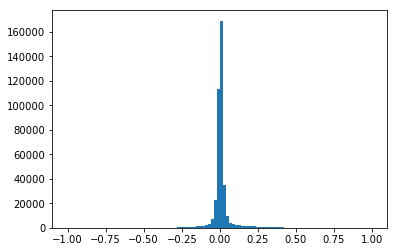

In [50]:
import matplotlib.pyplot as plt
plt.hist(3600 * (inphot['RA'] - rm['RA'][matchindx]), bins=100, range=(-1,1))
plt.show()

In [25]:
outtable = Table()
outtable.add_column(Column(data=rm['MEM_MATCH_ID']))
outtable.add_column(Column(data=rm['RA']))
outtable.add_column(Column(data=rm['DEC']))
outtable.add_column(Column(data=objid, name='REDMAPPER_OBJID'))
outtable.add_column(Column(data=newobjid, name='OBJID'))

outtable.add_column(Column(name=, name='OBJID'))



outtable.add_column(Column(name='MAGGIES', dtype='f4', shape=(7,), length=nobj))
outtable.add_column(Column(name='IVARMAGGIES', dtype='f4', shape=(7,), length=nobj))
#outtable

MEM_MATCH_ID,RA,DEC,OBJID,MAGGIES [7],IVARMAGGIES [7]
int32,float64,float64,int64,float32,float32
1,239.583329069,27.2334129178,1237662340012638224,0.0 .. 0.0,0.0 .. 0.0
2,250.082548387,46.7115313536,1237651715872325879,0.0 .. 0.0,0.0 .. 0.0
3,197.872957171,-1.34111627953,1237655500272500810,0.0 .. 0.0,0.0 .. 0.0
4,230.600091876,27.7143690526,1237664852576633380,0.0 .. 0.0,0.0 .. 0.0
5,137.300744635,10.9735949355,1237671260126576920,0.0 .. 0.0,0.0 .. 0.0
6,203.833722679,41.0011464409,1237662306722447498,0.0 .. 0.0,0.0 .. 0.0
7,8.03426455081,18.1070239389,1237678602382344780,0.0 .. 0.0,0.0 .. 0.0
8,340.832475838,-9.59192010688,1237652599036837935,0.0 .. 0.0,0.0 .. 0.0
9,150.558906081,20.5379493669,1237667541216985377,0.0 .. 0.0,0.0 .. 0.0


In [40]:
_run, _rerun, _camcol, _field, _id = unpack_objid(newobjid[indx])
(_field - inphot['FIELD']).max()

0

In [27]:
inphot['CAMCOL'].dtype

dtype('uint8')

In [ ]:
outtable['']

In [ ]:
outphotfile = os.path.join( os.getenv('REDMAPPER_DIR'), rmversion, 
                           'redmapper-{}-sdssWISEphot.fits'.format(rmversion) )
if os.path.isfile(outphotfile):
    print('Output photometry file {} exists.'.format(outphotfile))
else:
    print('Writing {}'.format(outphotfile))
    Table.write(outphotfile)

In [ ]:
1237678858480255092